# Proyecto Final Parte II: Clasificación-ensambles

![Logo Tec](img/LogoTec2.jpg)

## Ciencia y analítica de datos (Gpo 10)
### Alumnos: 
* Armando Bringas Corpus (A01200230), 
* Walter André Hauri Rosales (A01794237)

### Profesores: 
* Dra. María de la Paz Rico Fernández
* Mtra. Victoria Guerrero Orozco

### Fecha: 18 de noviembre de 2022

In [1]:
try:
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context ='notebook', ticks =True, grid =False) 
except ImportError as error:
   print('Not running in a Jupyter Notebook')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier


In [3]:
data = pd.read_csv("data/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020_limpio.csv", index_col=0)
data.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,...,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,...,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,...,Desconocido,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,...,Desconocido,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,...,Desconocido,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,...,Desconocido,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


## Selecciona de variables independientes X y dependiente Y (semáforo)

In [4]:
y = data["SEMAFORO"]
X = data.drop(columns=["SEMAFORO"])

In [5]:
X = X.select_dtypes(["float64"])

Cambia a label encoding el semáforo, ej, de ["clase 1", "clase 2", "clase 3"] a [ 1,2,3]. Desde la limpieza de datos se implemento el "label encoding" en la variable de salida

In [6]:
colores_semaforo = {'Amarillo': 0, 'Rojo': 1, 'Verde': 2}
y.unique() # Desde la limpieza se convritió a variable categórica

array([1, 2, 0], dtype=int64)

###  Análisis general de las features importances a través de decision trees o random forest

#### Decision Tree

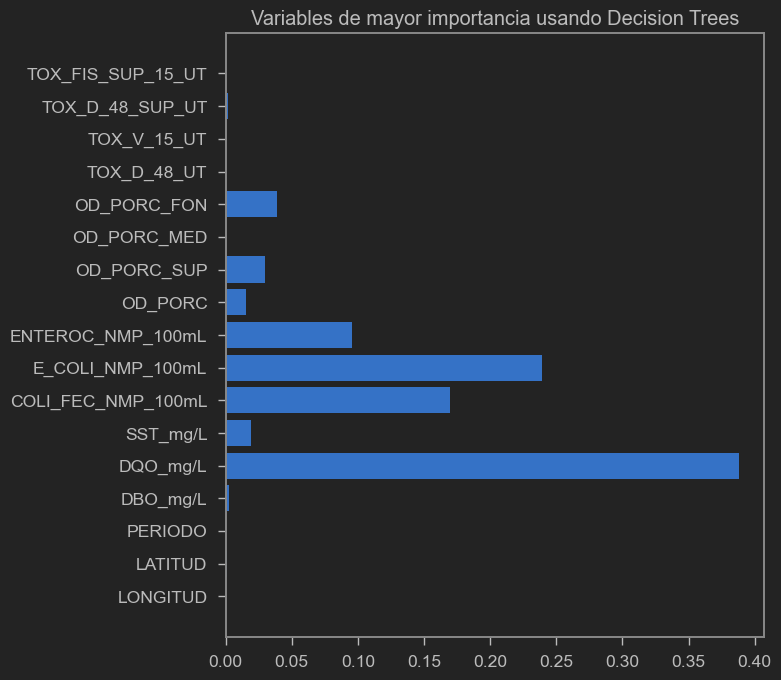

In [7]:
modelo_DT = DecisionTreeClassifier()
clf = modelo_DT.fit(X, y)

fig, ax = plt.subplots()
plt.barh(X.columns, width = clf.feature_importances_)
ax.set_title("Variables de mayor importancia usando Decision Trees")
fig.tight_layout()
plt.show()

#### Random Forest

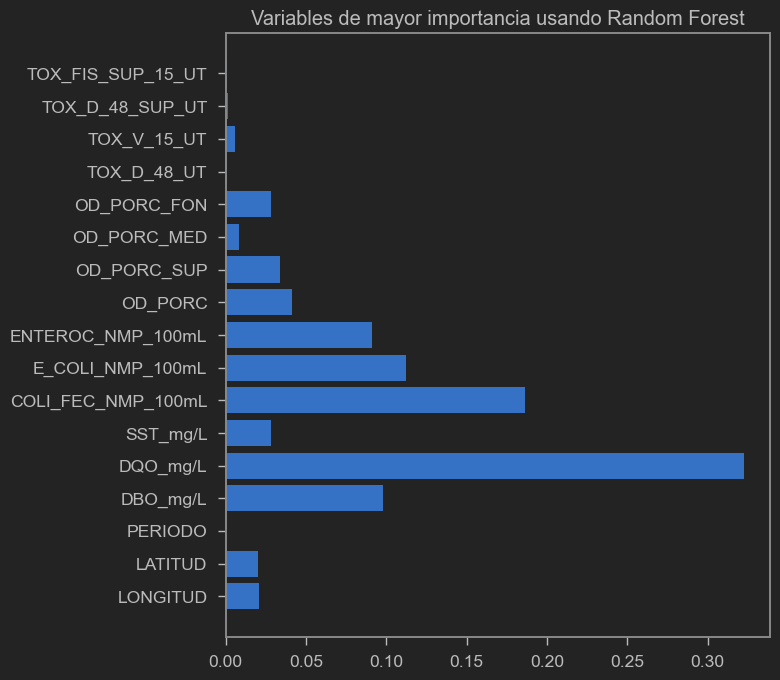

In [8]:
modelo_RF = RandomForestClassifier()
clf = modelo_RF.fit(X, y)

fig, ax = plt.subplots()
plt.barh(X.columns, width = clf.feature_importances_);
ax.set_title("Variables de mayor importancia usando Random Forest")
fig.tight_layout()
plt.show()

## Importancia de las Variables

### Primer Clasificador de las variables seleccionadas

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45, stratify=y)

### Random Forest

#### MDI (Mean Decrease in Impurity)

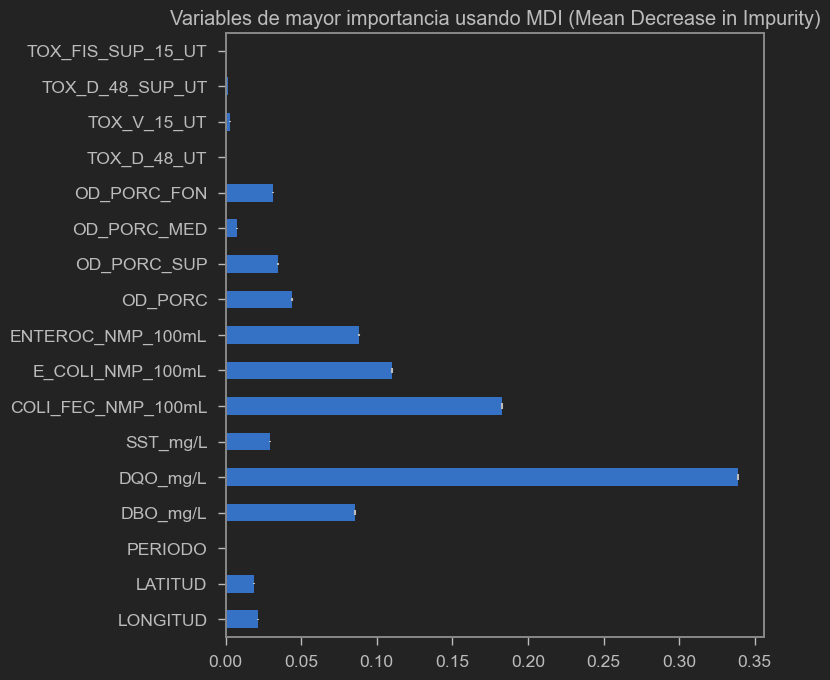

In [10]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Variables de mayor importancia usando MDI (Mean Decrease in Impurity)")
fig.tight_layout()
plt.show()

#### Permutación en el modelo completo

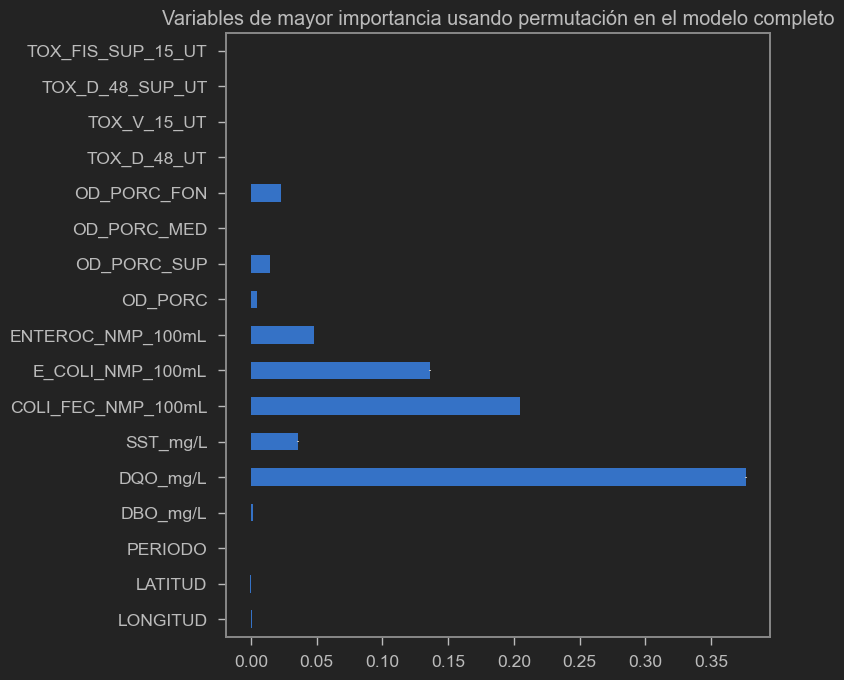

In [11]:
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=result.importances_std, ax=ax)
ax.set_title("Variables de mayor importancia usando permutación en el modelo completo")
fig.tight_layout()
plt.show()

### Selección de las variables de mayor importancia

Si comparamos las gráficas las mismas características son detectadas como más importantes en los método de MDI y permutación, sin embargo, en MDI es menos probable que omita alguna variable a comparación de la de permutación. Por lo tanto, seleccionamos las variables más importantes del método de MDI.


In [12]:
selected_X_variables = ['LONGITUD', 'LATITUD', 'DBO_mg/L', 'DQO_mg/L', 'SST_mg/L', 'COLI_FEC_NMP_100mL',
                       'E_COLI_NMP_100mL', 'ENTEROC_NMP_100mL', 'OD_PORC', 'OD_PORC_SUP', 'OD_PORC_FON',
                       'TOX_V_15_UT','TOX_D_48_SUP_UT']
X = data[selected_X_variables]

## Modelo

### Segundo clasificador con las variables más importantes

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45, stratify=y)

### Random Forest

In [14]:
mi_modelo_RF = RandomForestClassifier(random_state=45)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=45) # k-folds cross-validation

dicc_grid = {'ccp_alpha':[0.0, 0.0001, 0.001, 0.01, 0.1],
             'criterion': ["gini", "entropy", "log_loss"],
             'max_depth':range(1,21,2),
             'min_samples_split':range(2, 12, 2),
            }

grid = GridSearchCV(estimator=mi_modelo_RF, param_grid=dicc_grid, cv=cv, scoring="accuracy", n_jobs=-1)

grid.fit(X_train, np.ravel(y_train))

print('Mejor valor de accuracy obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
print('Métrica utilizada:', grid.scoring)

Mejor valor de accuracy obtenido con la mejor combinación: 0.9865192793924977
Mejor combinación de valores encontrados de los hiperparámetros: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 2}
Métrica utilizada: accuracy


#### Análisis de Resultados (Métricas de exactitud)

In [15]:
mejor_RF = grid.best_estimator_
y_hat = mejor_RF.predict(X_test)

## Metrics report
print(classification_report(y_test, y_hat, target_names=colores_semaforo))

              precision    recall  f1-score   support

    Amarillo       0.99      0.99      0.99       227
        Rojo       1.00      1.00      1.00       218
       Verde       0.98      0.99      0.99       254

    accuracy                           0.99       699
   macro avg       0.99      0.99      0.99       699
weighted avg       0.99      0.99      0.99       699



##### Gráfica de Precision Recall

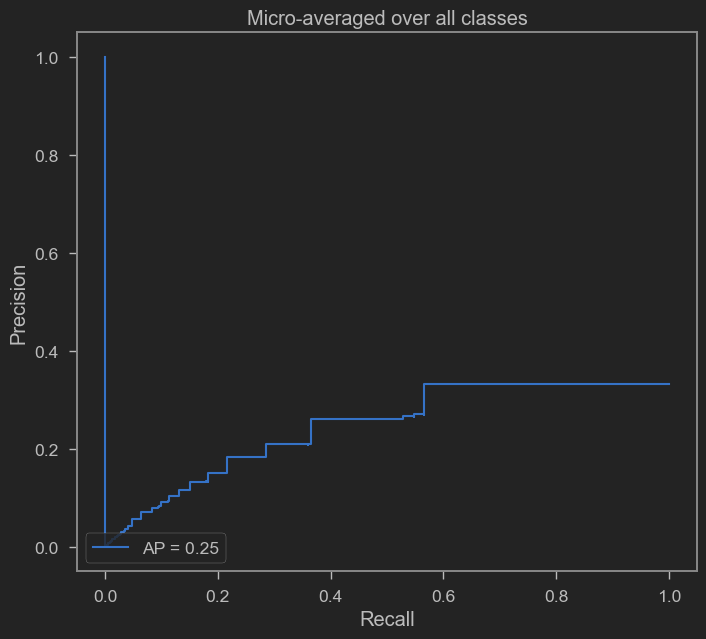

In [16]:
## Precision-recall plot
y_test_bin = label_binarize(y_test, classes=y.unique())
y_score = mejor_RF.predict_proba(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = y_train.unique().shape[0]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

##### Matriz de Confusión

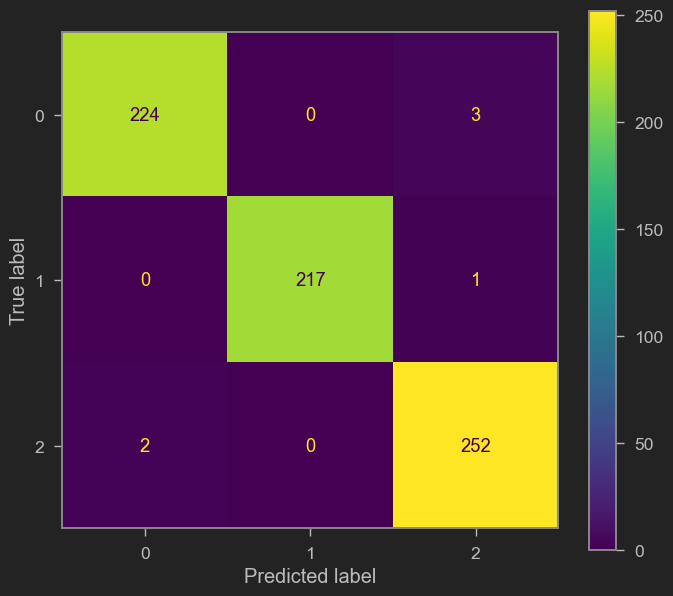

In [17]:
## Confusion matrix
cf_matrix = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat);

### Decision Tree

In [18]:
mi_modelo_DT = DecisionTreeClassifier(random_state=45)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=45) # k-folds cross-validation

dicc_grid = {'ccp_alpha':[0.0, 0.0001, 0.001, 0.01, 0.1],
             'criterion': ["gini", "entropy", "log_loss"],
             'max_depth':range(1,21,2),
             'min_samples_split':range(2, 12, 2),
             'class_weight':[None,'balanced'],
            }

grid = GridSearchCV(estimator=mi_modelo_RF, param_grid=dicc_grid, cv=cv, scoring="accuracy", n_jobs=-1)

grid.fit(X_train, np.ravel(y_train))

print('Mejor valor de accuracy obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
print('Métrica utilizada:', grid.scoring)

Mejor valor de accuracy obtenido con la mejor combinación: 0.9865192793924977
Mejor combinación de valores encontrados de los hiperparámetros: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 2}
Métrica utilizada: accuracy


#### Análisis de Resultados (Métricas de exactitud)

In [19]:
mejor_DT = grid.best_estimator_
y_hat = mejor_DT.predict(X_test)

## Metrics report
print(classification_report(y_test, y_hat, target_names=colores_semaforo))

              precision    recall  f1-score   support

    Amarillo       0.99      0.99      0.99       227
        Rojo       1.00      1.00      1.00       218
       Verde       0.98      0.99      0.99       254

    accuracy                           0.99       699
   macro avg       0.99      0.99      0.99       699
weighted avg       0.99      0.99      0.99       699



##### Gráfica de Precision Recall

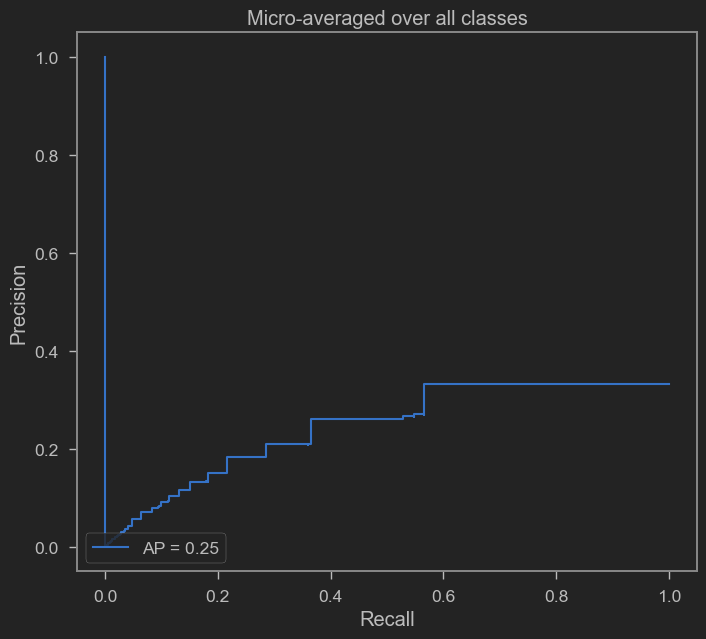

In [20]:
## Precision-recall plot
y_score = mejor_DT.predict_proba(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = y_train.unique().shape[0]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

##### Matriz de Confusión

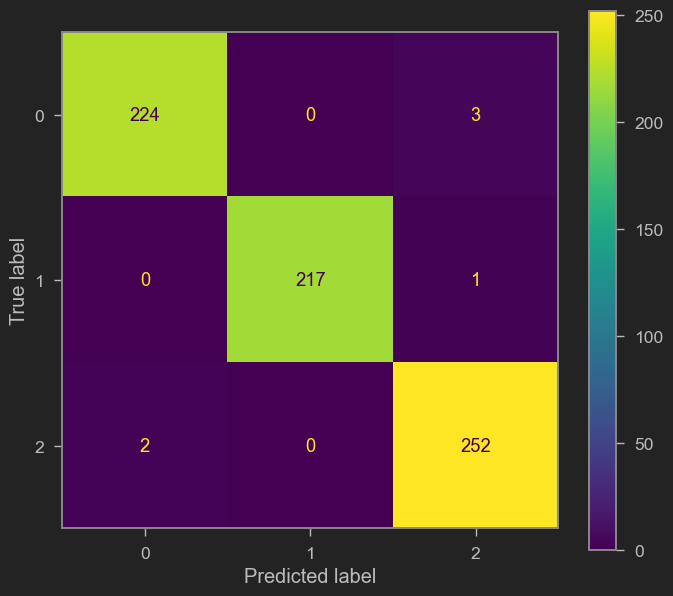

In [21]:
## Confusion matrix
cf_matrix = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat);

## Conclusiones

Emplear el modelo de Random Forest como clasificador en un inicio nos permitió hacer una selección de las variables de entrada más importantes y posteriormente construir los modelos de Random Forest y Decision trees para predicción. Encontramos que este tipo de algoritmos son muy versátiles tanto para tareas de clasificación y regresión, teniendo como variable de salida ya sea de tipo numérica o categórica.

Con respecto al 'Feature Importance', pudimos observar que existen ciertas variables que tienen mayor releva

De acuerdo a las predicciones que obtuvimos de ambos modelos, podemos observar que la precisión de ambos algoritmos, Decision Trees (precisión 'accuracy' de %99.99) y Random Forest (precisión 'accuracy' de %99) es similar, los dos funcionan de forma adecuada, sin embargo, el de Random Forest consume más tiempo computacional al ejecturse para realziar el 'Grid Search' por lo que tomando en consideración este último aspecto, para este caso particular es más conveniente usar Decision Trees y tuvo una exactitud ligeramente mejor.
